NOTE: Running this notebook requires running isic/food11/cub training on an imagenet pretrained model first, using the run_experiment.py file. 
Scripts to run these experiments with the config files employed in the paper can be found under /cluster_run/slurm/imagenet-transfer. This requires a setup with apptainer and slurm.

### Imports

In [1]:
import click
import os
import joblib
import json
import random
import copy
import logging
from tqdm import tqdm
import torch.nn as tnn
from PIL import Image
from glob import glob
import torchvision
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from experiment_utils.model import models as models
from experiment_utils.data import transforms as transforms
from experiment_utils.data import datasets as datasets
from experiment_utils.data import dataloaders as dataloaders
from lfprop.propagation import propagator_lxt as propagator
from experiment_utils.evaluation import evaluate as evaluate
from lfprop.rewards import rewards as rewards

from zennit import composites as zcomp
from zennit import core as zcore
from zennit import canonizers as zcanon

### Experiment Variables

In [2]:
dataset_name_base = "imagenet"
dataset_name_transfer = "cub" #alternatively, use "food11" or "isic"
model_name = "resnet18" #alternatively, use "resnet34", "vgg16", or "vgg16bn"
n_channels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
momentum=0.9
reward_name = "softmaxlossreward"
loss_name = "ce-loss"
norm_backward = True
activation="relu"
seeds = ["7240", "5110", "5628"]
methods = ["lfp-epsilon", "vanilla-gradient"]

recompute_accuracies = False
investigated_lr = 0.005 # used 0.005 for resnets, 0.001 for vgg16 models
investigated_ep_lfp = 100
investigated_ep_grad = 100

savepath = "<path to save results in>"
data_path_base = "<path where base dataset is saved>"
data_path_transfer = "<path where transfer dataset is saved>"

### ModelWrapper Class

In [3]:
def get_head(model):
    if isinstance(model, torchvision.models.VGG) or isinstance(model, torchvision.models.efficientnet.EfficientNet):
        head = [m for m in model.classifier.modules() if not isinstance(m, torch.nn.Sequential)][-1]
    elif isinstance(model, torchvision.models.ResNet) or isinstance(model, torchvision.models.Inception3):
        head = model.fc
    else:
        head = model.classifier[-1]
    return head

class ModelWrapper:
    def __init__(self, modelname, activation, n_channels, n_classes, savepath, savename, saveappendage, criterion, batch_size, device):
        self.modelname = modelname
        self.activation = activation
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.checkpointpath = os.path.join(savepath, f"{savename}-{saveappendage}.pt")
        self.criterion = criterion
        self.batch_size = batch_size
        self.device = device

        self.acc_log = {
            "train": [],
            "base": [],cifar100-cifar10-transfer
            batch_size = self.batch_size,
            shuffle = False,
        )

        return_dict = evaluate.eval(
            self.eval_model, 
            loader, 
            self.criterion, 
            device
        )
        
        return return_dict

    def load_head(self, dataset_name):
        in_features, out_features, head_state_dict = self.stored_heads[dataset_name]
        models.replace_torchvision_last_layer(self.model, out_features)
        head = get_head(self.model)
        head.load_state_dict(head_state_dict)

        self.model.to(self.device)

        self.model.eval()

    def load(self, dataset_name, replace_last_layer=True):   
        self.model = models.get_model(
            self.modelname, 
            self.n_channels, 
            self.n_classes, 
            self.device, 
            replace_last_layer=replace_last_layer,
            activation=self.activation,
        )
        if os.path.exists(self.checkpointpath):
            checkpoint = torch.load(self.checkpointpath)
            if self.model:
                self.model.load_state_dict(checkpoint["model"])
            if "acc_log" in checkpoint:
                self.acc_log = checkpoint["acc_log"]
            if "stored_heads" in checkpoint:
                self.stored_heads = checkpoint["stored_heads"]
            if "best_acc" in checkpoint:
                self.best_acc = checkpoint["best_acc"]
            self.global_epoch = checkpoint["epoch"]
            self.global_step = checkpoint["step"]

            torch.set_rng_state(checkpoint["random_state"]["torch"])
            torch.cuda.set_rng_state(checkpoint["random_state"]["cuda"], device)
            np.random.set_state(checkpoint["random_state"]["numpy"])
            random.setstate(checkpoint["random_state"]["random"])

            self.load_head(dataset_name)

        else:
            print("No checkpoint found... not loading anything.")

        self.model.eval()

    def remove(self):
        del self.model
        if hasattr(self, "stored_heads"):
            del self.stored_heads




### Paths, Dataset, Model

In [4]:
os.makedirs(data_path_base, exist_ok=True)
os.makedirs(data_path_transfer, exist_ok=True)

train_dataset_base = datasets.get_dataset(
    dataset_name_base,
    data_path_base,
    transforms.get_transforms(dataset_name_base, "train"),
    mode="train",
)
train_dataset_transfer = datasets.get_dataset(
    dataset_name_transfer,
    data_path_transfer,
    transforms.get_transforms(dataset_name_transfer, "train"),
    mode="train",
)
test_dataset_base = datasets.get_dataset(
    dataset_name_base,
    data_path_base,
    transforms.get_transforms(dataset_name_base, "test"),
    mode="test",
)
test_dataset_transfer = datasets.get_dataset(
    dataset_name_transfer,
    data_path_transfer,
    transforms.get_transforms(dataset_name_transfer, "test"),
    mode="test",
)

propagation_composites = {
    "lfp-epsilon": propagator.LFPEpsilonComposite(
        norm_backward=norm_backward, 
    ),
    "vanilla-gradient": None,
}

DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet
DATA_ROOT /media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/Datasets/imagenet


### Load Checkpoints

In [5]:
transfer_wrappers = {}

accuracies_basemodel = {
    dataset_name_base: {},
}
accuracies_transfermodel = {
    dataset_name_base: {},
    dataset_name_transfer: {}
}

filepath_base = os.path.join(savepath, f"accuracies_basemodel-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
filepath_transfer = os.path.join(savepath, f"accuracies_transfermodel-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")

for fulldir in glob(os.path.join(savepath, "*.yaml*")):
    dir = fulldir.split("/")[-1]
    runparams = dir.split(".yaml")[0].split("_")[:-1]

    lr, prop_comp, seed = float(runparams[2]), runparams[3], runparams[7]

    print(f"{lr}, {prop_comp}, {seed}")

    if float(lr) == float(investigated_lr):

        if lr not in transfer_wrappers.keys():
            transfer_wrappers[lr] = {}
            accuracies_basemodel[dataset_name_base][lr] = {}
            accuracies_transfermodel[dataset_name_base][lr] = {}
            accuracies_transfermodel[dataset_name_transfer][lr] = {}
        if prop_comp not in transfer_wrappers[lr].keys():
            transfer_wrappers[lr][prop_comp] = {}
            accuracies_basemodel[dataset_name_base][lr][prop_comp] = {}
            accuracies_transfermodel[dataset_name_base][lr][prop_comp] = {}
            accuracies_transfermodel[dataset_name_transfer][lr][prop_comp] = {}

        ckpt_path = os.path.join(fulldir, "output", seed, "ckpts")
        ie = investigated_ep_grad if prop_comp=="vanilla-gradient" else investigated_ep_lfp
        if ie == 100:
            saveappendage = "last"
        else:
            saveappendage = f"ep-{ie}"
        transfer_wrappers[lr][prop_comp][seed] = (
            ModelWrapper(
                modelname=model_name, 
                activation=activation, 
                n_channels=n_channels,
                n_classes = len(test_dataset_base.classes), 
                savepath=ckpt_path, 
                savename="base-model", 
                saveappendage="last", 
                criterion=rewards.get_reward(reward_name, device) if prop_comp is not None else rewards.get_reward(loss_name, device),
                batch_size=batch_size,
                device=device
            ),
            ModelWrapper(
                modelname=model_name, 
                activation=activation, 
                n_channels=n_channels,
                n_classes = len(test_dataset_transfer.classes), 
                savepath=ckpt_path, 
                savename="transfer-model", 
                saveappendage=saveappendage, 
                criterion=rewards.get_reward(reward_name, device) if prop_comp is not None else rewards.get_reward(loss_name, device),
                batch_size=batch_size,
                device=device
            ),
        )

        print("Evaluating Models...")
        if recompute_accuracies or not os.path.exists(filepath_base):
            print("Evaluating Models...")
            # Eval base accuracy
            #print("Eval base base")
            res = transfer_wrappers[lr][prop_comp][seed][0].eval(test_dataset_base, dataset_name_base, replace_last_layer=False)
            accuracies_basemodel[dataset_name_base][lr][prop_comp][seed] = float(res["accuracy_p050"]) if "accuracy_p050" in res.keys() else float(res["micro_accuracy_top1"])
            transfer_wrappers[lr][prop_comp][seed][0].remove()

        if recompute_accuracies or not os.path.exists(filepath_transfer):
            # Eval transfer accuracy base dataset
            #print("Eval transfer base")
            res = transfer_wrappers[lr][prop_comp][seed][1].eval(test_dataset_base, dataset_name_base, replace_last_layer=True)
            accuracies_transfermodel[dataset_name_base][lr][prop_comp][seed] = float(res["accuracy_p050"]) if "accuracy_p050" in res.keys() else float(res["micro_accuracy_top1"])

            # Eval transfer accuracy transfer dataset
            #print("Eval transfer transfer")
            res = transfer_wrappers[lr][prop_comp][seed][1].eval(test_dataset_transfer, dataset_name_transfer, replace_last_layer=True)
            accuracies_transfermodel[dataset_name_transfer][lr][prop_comp][seed] = float(res["accuracy_p050"]) if "accuracy_p050" in res.keys() else float(res["micro_accuracy_top1"])
            transfer_wrappers[lr][prop_comp][seed][1].remove()

            print(f"Accuracies Base: (Base) {accuracies_basemodel[dataset_name_base][lr][prop_comp][seed]:.2f} Accuracies Transfer: (Base) {accuracies_transfermodel[dataset_name_base][lr][prop_comp][seed]:.2f}, (Transfer) {accuracies_transfermodel[dataset_name_transfer][lr][prop_comp][seed]:.2f}")

    else:
        print("SKIPPING...")

if os.path.exists(filepath_base) and not recompute_accuracies:
    accuracies_basemodel = joblib.load(filepath_base)
if os.path.exists(filepath_transfer) and not recompute_accuracies:
    accuracies_transfermodel = joblib.load(filepath_transfer)  
joblib.dump(accuracies_basemodel, filepath_base)
joblib.dump(accuracies_transfermodel, filepath_transfer)

0.005, lfp-epsilon, 5628
Evaluating Models...
0.005, vanilla-gradient, 7240
Evaluating Models...
0.005, lfp-epsilon, 7240
Evaluating Models...
0.005, vanilla-gradient, 5110
Evaluating Models...
0.005, lfp-epsilon, 5110
Evaluating Models...
0.005, vanilla-gradient, 5628
Evaluating Models...


['/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/imagenet-transfer-cluster-resnet18-cub/accuracies_transfermodel-0.005-100-100.joblib']

In [6]:
# Plot Settings
# Set font properties.
import matplotlib.font_manager as font_manager
from matplotlib import ticker
import matplotlib.cm as cm
font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams['axes.linewidth'] = 1.5

### Plot Val Accuracies

imagenet
MAX: lfp-epsilon - 0.005 - 0.12433334439992905
MAX: vanilla-gradient - 0.005 - 0.16466666758060455


/tmp/ipykernel_724463/304449091.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


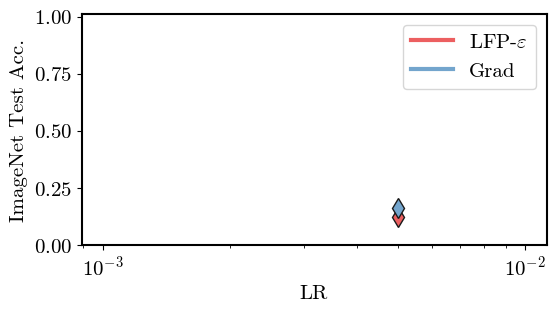

cub
MAX: lfp-epsilon - 0.005 - 0.6843510270118713
MAX: vanilla-gradient - 0.005 - 0.7074852585792542


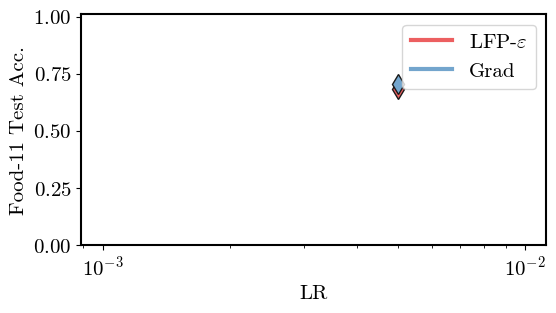

In [7]:
def plot_accuracies(accuracy_res, fname, colormap="Set1", dataset_readable=""):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    lrs = sorted([lr for lr in accuracy_res.keys()])
    methods = sorted([m for m in accuracy_res[lrs[0]].keys()])

    #print(lrs)
    #print(methods)

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
            "lfp-epsilon": r"LFP-$\varepsilon$",
            "lfp-zplus-zminus": r"LFP-$z^+z^-$",
            "vanilla-gradient": r"Grad",
        }

    maxacclrs = []

    for m, method in enumerate(methods):
        plot_means = []
        plot_stds = []
        for lr in lrs:
            ar = [accuracy_res[lr][method][seed] for seed in accuracy_res[lr][method].keys()]
            plot_means.append(np.mean(ar))
            plot_stds.append(np.std(ar))

            #print(method, lr, np.mean(ar))

        plot_means = np.array(plot_means)
        plot_stds = np.array(plot_stds)

        maxx = lrs[np.argmax(plot_means)]
        maxy = np.max(plot_means)
        print(f"MAX: {method} - {maxx} - {maxy}")
        maxacclrs.append((method, maxx, maxy))

        ax.plot(lrs, plot_means, color=palette[m], label=LABELS[method], linewidth=3)
        ax.plot(maxx, maxy, color=palette[m], marker="d", markersize=10, markeredgecolor=(0.1, 0.1, 0.1, 1))
        ax.fill_between(lrs, plot_means+plot_stds, plot_means-plot_stds, color=palette[m], alpha=0.2)

    ax.legend()
    ax.set_xscale('log')
    #ax.set_xlim([0, 10e-2])
    ax.set_ylabel(f"{dataset_readable} Test Acc.")
    ax.set_xlabel("LR")
    ax.set_ylim([0, 1.01])
    plt.show()
    fig.savefig(fname)

    return maxacclrs

maxacclrs2 = {}
for name, val in accuracies_transfermodel.items():
    print(name)
    fname = os.path.join(savepath, f"accuracies_transfermodel-{name}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
    maxacclrs2[name] = plot_accuracies(val, fname, dataset_readable="ImageNet" if name=="imagenet" else "Food-11")

### Zennit Patch for Parameter Relevance

In [8]:
def new_backward(self, module, grad_input, grad_output):
    '''Backward hook to compute LRP based on the class attributes.'''

    original_input = self.stored_tensors['input'][0].clone()
    param_keys = [name for name, _ in module.named_parameters(recurse=False)]

    inputs = []
    outputs = []
    params = {k: [] for k in param_keys}

    module.param_relevances = {}

    for in_mod, param_mod, out_mod in zip(self.input_modifiers, self.param_modifiers, self.output_modifiers):
        input = in_mod(original_input).requires_grad_()
        with zcore.ParamMod.ensure(param_mod)(module) as modified, torch.autograd.enable_grad():
            output = modified.forward(input)
            output = out_mod(output)

            for key in param_keys:
                if getattr(modified, key) is not None:
                    params[key].append(getattr(modified, key))

        inputs.append(input)
        outputs.append(output)
    grad_outputs = self.gradient_mapper(grad_output[0], outputs)
    gradients = torch.autograd.grad(
        outputs,
        inputs,
        grad_outputs=grad_outputs, 
        retain_graph=True,
        create_graph=False #grad_output[0].requires_grad
    )
    relevance = self.reducer(inputs, gradients)

    for key in param_keys:
        param_gradients = torch.autograd.grad(
            outputs, 
            params[key], 
            grad_outputs=self.gradient_mapper(grad_output[0], outputs), 
            retain_graph=True, 
            create_graph=False #grad_output[0].requires_grad
        )

        param_relevance = self.reducer(params[key], param_gradients)
        module.param_relevances[key] = param_relevance

    return tuple(relevance if original.shape == relevance.shape else None for original in grad_input)

zcore.BasicHook.backward = new_backward
    

# Pruning

In [9]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
recompute_pruning = False
num_weights = 1000

relevance_loader = dataloaders.get_dataloader(
    dataset_name = dataset_name_transfer,
    dataset = test_dataset_transfer,
    batch_size = 32,
    shuffle = True,
)
class EpsilonComp(zcomp.LayerMapComposite):
    def __init__(self, canonizers=None):
        layer_map = zcomp.layer_map_base(stabilizer=1e-6) + [
            (zcomp.Convolution, zcomp.Epsilon()),
            (torch.nn.Linear, zcomp.Epsilon()),
        ]
        super().__init__(layer_map, canonizers=canonizers)

class ZplusComp(zcomp.LayerMapComposite):
    def __init__(self, canonizers=None):
        layer_map = zcomp.layer_map_base(stabilizer=1e-6) + [
            (zcomp.Convolution, zcomp.ZPlus()),
            (torch.nn.Linear, zcomp.ZPlus()),
        ]
        super().__init__(layer_map, canonizers=canonizers)
composite = EpsilonComp(canonizers=[zcanon.SequentialMergeBatchNorm()])
#composite = ZplusComp(canonizers=[zcanon.SequentialMergeBatchNorm()])

### Weight Distribution

/tmp/ipykernel_724463/2835304139.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


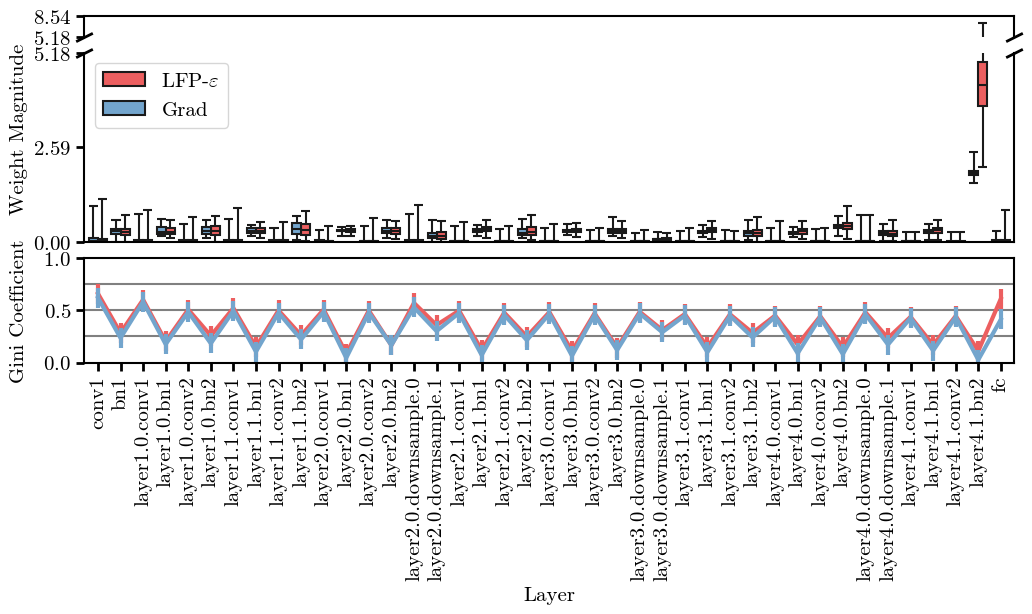

/tmp/ipykernel_724463/2835304139.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


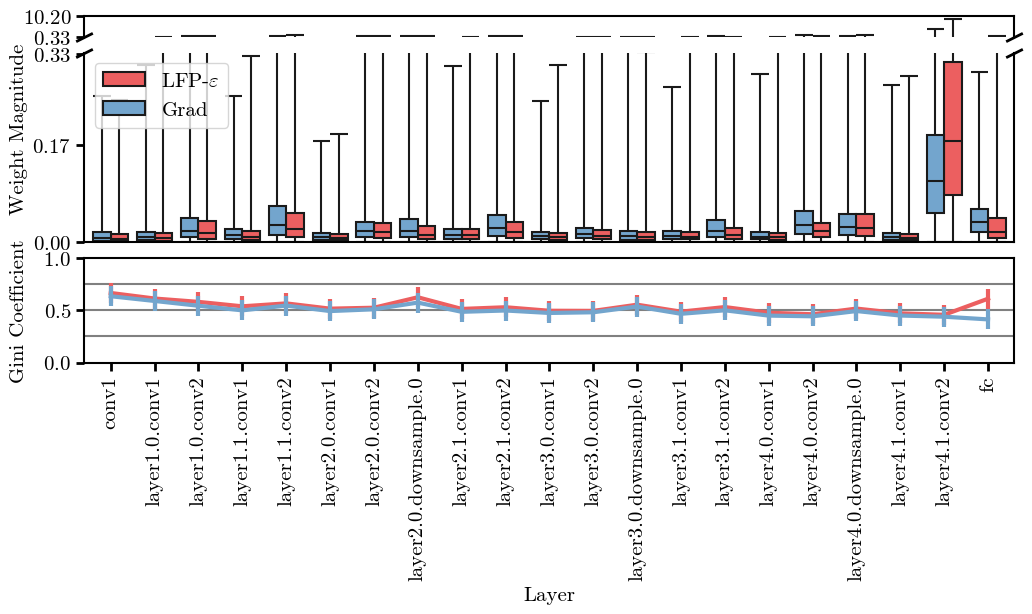

/tmp/ipykernel_724463/2835304139.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


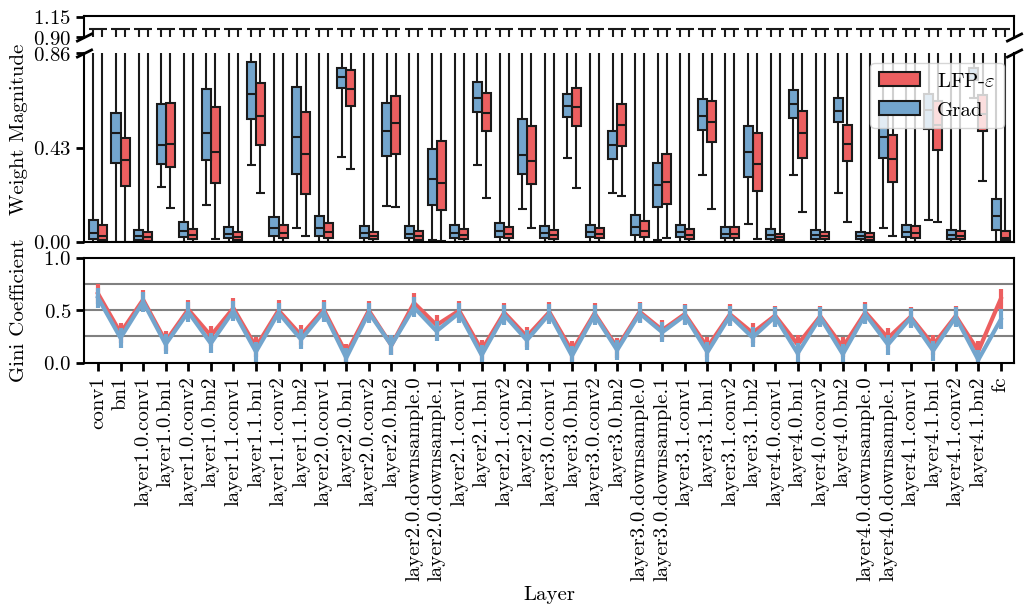

/tmp/ipykernel_724463/2835304139.py:71: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


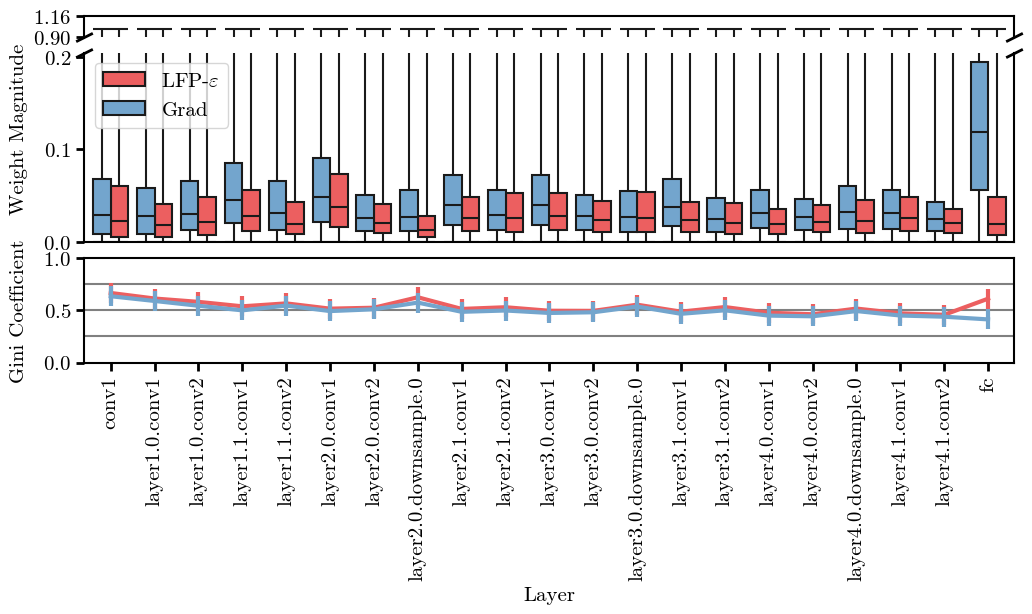

In [10]:
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

def gini_idx(param):
    param = param.detach().abs()
    sorted, indices = torch.sort(param.view(-1))

    sortedidx=torch.arange(0, sorted.numel(), 1).to(param.device)

    gini_numerator = 2 * (sorted * sortedidx).sum()
    gini_denominator = sorted.numel() * sorted.sum()
    gini_addendum = (sorted.numel() + 1) / sorted.numel()

    return gini_numerator/gini_denominator - gini_addendum

def compute_weight_distribution(layers):
    
    percentiles = {}

    for name, layer in layers:
        perc = []
        for q in [0.0, 0.25, 0.5, 0.75, 1.0]:
            layerdata = layer.weight.data.abs().view(-1)
            kth = torch.kthvalue(layerdata, torch.arange(1, layerdata.numel()+1)[int(q*(layerdata.numel()-1))]).values
            perc.append(kth.item())
        
        percentiles[name] = perc

    return percentiles

def compute_normed_weight_distribution(layers):
    
    percentiles = {}

    for name, layer in layers:
        perc = []
        for q in [0.0, 0.25, 0.5, 0.75, 1.0]:
            layerdata = layer.weight.data.abs().view(-1)/layer.weight.data.abs().amax()
            kth = torch.kthvalue(layerdata, torch.arange(1, layerdata.numel()+1)[int(q*(layerdata.numel()-1))]).values
            perc.append(kth.item())
        
        percentiles[name] = perc

    return percentiles

def compute_gini_idx(layers):
    ginis = {}

    for name, layer in layers:
        layerdata = layer.weight.data.abs().view(-1)
        ginis[name] = gini_idx(layerdata).detach().cpu().numpy()

    return ginis

def compute_normed_gini_idx(layers):
    ginis = {}

    for name, layer in layers:
        layerdata = layer.weight.data.abs().view(-1)/layer.weight.data.abs().amax()
        ginis[name] = gini_idx(layerdata).detach().cpu().numpy()

    return ginis

def plot_barplot(perc, fname, colormap="Set1"):

    #fig = plt.figure(figsize=(15, 3))
    fig, axes = plt.subplots(3, 1, figsize=(12, 4.5), sharex=True, height_ratios=[0.3, 2.7, 1.5])
    fig.subplots_adjust(hspace=0.15)

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))
    

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    yoffset = 0.0
    y_cut_1 = None
    y_cut_2 = None
  
    quants = perc["quantiles"]
    gini = perc["gini"]

    # Get ycuts
    for m, method in enumerate(methods):
        q_means = {}
        lr = investigated_lr
        for s, seedarr in enumerate(quants[method][lr]):
            for layer, quant in seedarr.items():
                if layer not in q_means.keys():
                    q_means[layer] = []
                q_means[layer].append(quant)

        for layer in q_means.keys():
            q_means[layer] = np.mean(q_means[layer], axis=0)

        yvals = np.array(list(q_means.values()))
        q_75 = yvals[:, 3]
        q_100 = yvals[:, 4]

        y_cut_1 = np.max(q_75) if y_cut_1 == None else np.max([np.max(q_75), y_cut_1])
        y_cut_2 = np.min(q_100) if y_cut_2 == None else np.min([np.min(q_100), y_cut_2])

    y_cut_1 += 0.05*y_cut_1
    y_cut_2 -= 0.1*y_cut_2
    y_cut_2 = np.max([y_cut_1, y_cut_2])

    # Plot
    for m, method in enumerate(methods):
        q_means = {}
        gini_means = {}
        lr = investigated_lr
        for s, seedarr in enumerate(quants[method][lr]):
            for layer, quant in seedarr.items():
                if layer not in q_means.keys():
                    q_means[layer] = []
                    gini_means[layer] = []
                q_means[layer].append(quant)
                gini_means[layer].append(gini[method][lr][s][layer])

        for layer in q_means.keys():
            q_means[layer] = np.mean(q_means[layer], axis=0)
            gini_means[layer] = np.mean(gini_means[layer], axis=0)

        xticks = np.arange(len(list(q_means.keys())))
        yvals = np.array(list(q_means.values()))

        yvals_gini = np.array(list(gini_means.values()))
        q_0 = yvals[:, 0]
        q_25 = yvals[:, 1]
        q_50 = yvals[:, 2]
        q_75 = yvals[:, 3]
        q_100 = yvals[:, 4]

        width=0.4 if m == 0 else -0.4

        for a, ax in enumerate([axes[0], axes[1]]):

            if a == 1:
                drawfilter = np.ones_like(q_75) == 1
            else:
                drawfilter = q_75 >= y_cut_2
            ax.bar(xticks[drawfilter], (q_75-q_25)[drawfilter]+yoffset, color=palette[m], bottom=q_25[drawfilter]+yoffset, edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5, align="edge", width=width)

            if a == 1:
                drawfilter = np.ones_like(q_0) == 1
            else:
                drawfilter = q_0 >= y_cut_2
            ax.hlines(q_0[drawfilter]+yoffset, xmin=xticks[drawfilter], xmax=xticks[drawfilter]+width, color=(0.1, 0.1, 0.1, 1), linewidth=1.5)

            if a == 1:
                drawfilter = np.ones_like(q_100) == 1
            else:
                drawfilter = q_100 >= y_cut_2
            ax.hlines(q_100[drawfilter]+yoffset, xmin=xticks[drawfilter], xmax=xticks[drawfilter]+width, color=(0.1, 0.1, 0.1, 1), linewidth=1.5)

            if a == 1:
                drawfilter = np.ones_like(q_50) == 1
            else:
                drawfilter = q_50 >= y_cut_2
            ax.hlines(q_50[drawfilter]+yoffset, xmin=xticks[drawfilter], xmax=xticks[drawfilter]+width, color=(0.1, 0.1, 0.1, 1), linewidth=1.5)

            ax.vlines(xticks+width/2, ymin=q_0+yoffset, ymax=q_25+yoffset, color=(0.1, 0.1, 0.1, 1), linewidth=1.5)
            ax.vlines(xticks+width/2, ymin=q_75+yoffset, ymax=q_100+yoffset, color=(0.1, 0.1, 0.1, 1), linewidth=1.5)

        axes[2].plot(yvals_gini, color=palette[m], marker="|", linewidth=3, markersize=15, mew=3)

    linelocs = [0.25, 0.5, 0.75]
    axes[2].hlines(linelocs, xmin=-0.6, xmax=len(xticks)-0.4, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    legend_handles = []
    for m, method in enumerate(methods):
        legend_handles.append(axes[0].bar([-10], [0.01], color=palette[m], label=LABELS[method], edgecolor=(0.1, 0.1, 0.1, 1), linewidth=1.5))

    axes[1].legend(handles=legend_handles)
    axes[2].set_xlabel("Layer")
    #axes[2].set_ylabel("Gini Coefficient")
    fig.text(-0.08, 0.6, "Weight Magnitude", va="center", rotation="vertical", fontsize=rcParams["axes.labelsize"], transform=axes[1].transAxes)
    fig.text(-0.08, 0.5, "Gini Coefficient", va="center", rotation="vertical", fontsize=rcParams["axes.labelsize"], transform=axes[2].transAxes)
    axes[2].set_xticks(xticks)
    axes[2].set_xticklabels(list(q_means.keys()), rotation=90)
    
    axes[0].set_xlim([-0.6, len(xticks)-0.4])
    axes[1].set_xlim([-0.6, len(xticks)-0.4])
    axes[2].set_xlim([-0.6, len(xticks)-0.4])
    
    axes[0].tick_params(axis="y", length=6, width=2)
    axes[0].tick_params(axis="x", length=0, width=0)
    axes[1].tick_params(axis="y", length=6, width=2)
    axes[1].tick_params(axis="x", length=0, width=0)
    #axes[1].tick_params(length=6, width=2)
    axes[2].tick_params(length=6, width=2)
    
    axes[0].set_ylim([y_cut_2, axes[0].get_ylim()[1]+0.1*axes[1].get_ylim()[1]])
    #axes[1].set_ylim([y_cut_1, y_cut_2])
    axes[1].set_ylim([0, y_cut_1])
    axes[2].set_ylim([0, 1])

    axes[0].spines.bottom.set_visible(False)
    #axes[0].spines.top.set_visible(False)
    #axes[1].spines.bottom.set_visible(False)
    #axes[1].spines.top.set_visible(False)
    axes[1].spines.top.set_visible(False)
    axes[1].xaxis.tick_bottom()

    axes[0].set_yticks([np.round(axes[0].get_ylim()[0], decimals=2), np.round(axes[0].get_ylim()[1], decimals=2)])
    axes[1].set_yticks([np.round(axes[1].get_ylim()[0], decimals=2), np.round((axes[1].get_ylim()[1]-axes[1].get_ylim()[0])/2, decimals=2), np.round(axes[1].get_ylim()[1], decimals=2)])
    #axes[1].set_yticks([0])
    axes[2].set_yticks([0, 0.5, 1.0])

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=2, clip_on=False)
    axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
    #axes[1].plot([0, 1], [0, 0], transform=axes[1].transAxes, **kwargs)
    #axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)
    axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

    plt.show()
    fn = fname.split(".svg")[0]
    fig.savefig(f"{fn}-{method}.svg")

p_rel_file = os.path.join(savepath, f"{dataset_name_transfer}-w_dist-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_rel_file) or recompute_pruning:
    p_rel = {
        "quantiles": {},
        "gini": {}
    }
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        if name not in p_rel["quantiles"].keys():
            p_rel["quantiles"][name] = {}
            p_rel["gini"][name] = {}
        if lr not in p_rel["quantiles"][name].keys():
            p_rel["quantiles"][name][lr] = []
            p_rel["gini"][name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            layers = [(n, m) for n, m in transfer_wrappers[lr][name][seed][1].model.named_modules() if hasattr(m, "weight")]
            parameter_rel = compute_weight_distribution(layers)
            gini = compute_gini_idx(layers)
            transfer_wrappers[lr][name][seed][1].remove()
            p_rel["quantiles"][name][lr].append(parameter_rel)
            p_rel["gini"][name][lr].append(gini)
    joblib.dump(p_rel, p_rel_file)
else:
    p_rel = joblib.load(p_rel_file)

fname = os.path.join(savepath, f"{dataset_name_transfer}-w_dist-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_barplot(p_rel, fname)

p_rel_file = os.path.join(savepath, f"{dataset_name_transfer}-w_dist_canonized-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_rel_file) or recompute_pruning:
    p_rel = {
        "quantiles": {},
        "gini": {}
    }
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        if name not in p_rel["quantiles"].keys():
            p_rel["quantiles"][name] = {}
            p_rel["gini"][name] = {}
        if lr not in p_rel["quantiles"][name].keys():
            p_rel["quantiles"][name][lr] = []
            p_rel["gini"][name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            canon = zcanon.SequentialMergeBatchNorm()
            handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
            layers = [(n, m) for n, m in transfer_wrappers[lr][name][seed][1].model.named_modules() if hasattr(m, "weight") and not isinstance(m, torch.nn.BatchNorm2d)]
            parameter_rel = compute_weight_distribution(layers)
            gini = compute_gini_idx(layers)
            for handle in handles:
                handle.remove()
            transfer_wrappers[lr][name][seed][1].remove()
            p_rel["quantiles"][name][lr].append(parameter_rel)
            p_rel["gini"][name][lr].append(gini)
    joblib.dump(p_rel, p_rel_file)
else:
    p_rel = joblib.load(p_rel_file)

fname = os.path.join(savepath, f"{dataset_name_transfer}-w_dist_canonized-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_barplot(p_rel, fname)

p_rel_file = os.path.join(savepath, f"{dataset_name_transfer}-w_dist_normed-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_rel_file) or recompute_pruning:
    p_rel = {
        "quantiles": {},
        "gini": {}
    }
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        if name not in p_rel["quantiles"].keys():
            p_rel["quantiles"][name] = {}
            p_rel["gini"][name] = {}
        if lr not in p_rel["quantiles"][name].keys():
            p_rel["quantiles"][name][lr] = []
            p_rel["gini"][name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            layers = [(n, m) for n, m in transfer_wrappers[lr][name][seed][1].model.named_modules() if hasattr(m, "weight")]
            parameter_rel = compute_normed_weight_distribution(layers)
            gini = compute_normed_gini_idx(layers)
            transfer_wrappers[lr][name][seed][1].remove()
            p_rel["quantiles"][name][lr].append(parameter_rel)
            p_rel["gini"][name][lr].append(gini)
    joblib.dump(p_rel, p_rel_file)
else:
    p_rel = joblib.load(p_rel_file)

fname = os.path.join(savepath, f"{dataset_name_transfer}-w_dist_normed-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_barplot(p_rel, fname)

p_rel_file = os.path.join(savepath, f"{dataset_name_transfer}-w_dist_normed_canonized-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_rel_file) or recompute_pruning:
    p_rel = {
        "quantiles": {},
        "gini": {}
    }
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        if name not in p_rel["quantiles"].keys():
            p_rel["quantiles"][name] = {}
            p_rel["gini"][name] = {}
        if lr not in p_rel["quantiles"][name].keys():
            p_rel["quantiles"][name][lr] = []
            p_rel["gini"][name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            canon = zcanon.SequentialMergeBatchNorm()
            handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
            layers = [(n, m) for n, m in transfer_wrappers[lr][name][seed][1].model.named_modules() if hasattr(m, "weight") and not isinstance(m, torch.nn.BatchNorm2d)]
            parameter_rel = compute_normed_weight_distribution(layers)
            gini = compute_normed_gini_idx(layers)
            for handle in handles:
                handle.remove()
            transfer_wrappers[lr][name][seed][1].remove()
            p_rel["quantiles"][name][lr].append(parameter_rel)
            p_rel["gini"][name][lr].append(gini)
    joblib.dump(p_rel, p_rel_file)
else:
    p_rel = joblib.load(p_rel_file)

fname = os.path.join(savepath, f"{dataset_name_transfer}-w_dist_normed_canonized-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_barplot(p_rel, fname)

### Weight Pruning

In [11]:
def compute_aggregated_relevances(trainer, layers, composite, loader, device, num_classes):

    for samples, labels in loader:
        
        samples = samples.to(device)
        labels = labels.to(device)

        eye = torch.eye(num_classes, device=device)
        one_hot = eye[labels]

        with composite.context(trainer.model) as modified:
            inputs = samples.detach().requires_grad_(True)


            outputs = modified(inputs)

            # Compute Relevance
            input_relevance = torch.autograd.grad((outputs,),
                                            (inputs,),
                                            grad_outputs=(one_hot,),
                                            retain_graph=False)[0]

        for layer in layers:
            if not hasattr(layer, "aggregated_param_relevances"):
                layer.aggregated_param_relevances = {k: 0 for k, _ in layer.param_relevances.items()}
            for key, val in layer.param_relevances.items():
                layer.aggregated_param_relevances[key] += val

def get_prunemask(trainer, layers, p=0.05, criterion="min", pruning_criterion="relevance", structured=False):

    if not hasattr(layers[0], "aggregated_param_relevances") and pruning_criterion == "relevance":
        compute_aggregated_relevances(trainer, layers, composite, relevance_loader, device, len(test_dataset_transfer.classes))

    if structured:
        crit_tensor = torch.cat([layer.weight.data.abs().sum(dim=(1, 2, 3)).view(-1) if pruning_criterion == "weight" else layer.aggregated_param_relevances["weight"].abs().sum(dim=(1, 2, 3)).view(-1) for layer in layers])
    else:
        crit_tensor = torch.cat([layer.weight.data.view(-1) if pruning_criterion == "weight" else layer.aggregated_param_relevances["weight"].view(-1) for layer in layers])

    prune_mask = torch.ones_like(crit_tensor)
    toprune = int(crit_tensor.numel()*p)

    if criterion == "min":
        topk = torch.topk(torch.abs(crit_tensor), k=toprune, largest=False)
    else:
        topk = torch.topk(torch.abs(crit_tensor), k=toprune, largest=True)

    prune_mask[topk.indices] = 0

    return prune_mask

def get_prunemask_local(trainer, layers, p=0.05, criterion="min", pruning_criterion="relevance", structured=False):

    if not hasattr(layers[0], "aggregated_param_relevances") and pruning_criterion == "relevance":
        compute_aggregated_relevances(trainer, layers, composite, relevance_loader, device, len(test_dataset_transfer.classes))

    if structured:
        crit_tensor = [layer.weight.data.abs().sum(dim=(1, 2, 3)).view(-1) if pruning_criterion == "weight" else layer.aggregated_param_relevances["weight"].abs().sum(dim=(1, 2, 3)).view(-1) for layer in layers]
    else:
        crit_tensor = [layer.weight.data.view(-1) if pruning_criterion == "weight" else layer.aggregated_param_relevances["weight"].view(-1) for layer in layers]

    prune_mask = [torch.ones_like(c) for c in crit_tensor]

    for l, layer in enumerate(layers):
        toprune = int(crit_tensor[l].numel()*p)

        if criterion == "min":
            topk = torch.topk(torch.abs(crit_tensor[l]), k=toprune, largest=False)
        else:
            topk = torch.topk(torch.abs(crit_tensor[l]), k=toprune, largest=True)

        prune_mask[l][topk.indices] = 0

    return torch.cat(prune_mask)

def get_prune_acc(trainer, layers, p=0.05, pruning_criterion="weight", structured=False, mask_function=get_prunemask):

    prune_rates = np.clip(np.arange(p, 1+p, p), 0, 1)

    res = trainer.eval(test_dataset_transfer, dataset_name_transfer)
    prune_accs = [float(res["accuracy_p050"]) if "accuracy_p050" in res.keys() else float(res["micro_accuracy_top1"])]
    print("Pruning...")
    with tqdm(total=len(prune_rates)) as pbar:
        for rate in prune_rates:
            prune_mask = mask_function(trainer, layers, p=rate, criterion="min", pruning_criterion=pruning_criterion, structured=structured)
            pointer = 0
            for layer in layers:
                if structured:
                    numel = layer.weight.data.shape[0]
                    layer.weight.data *= prune_mask[pointer:pointer+numel][:, None, None, None]
                else:
                    numel = layer.weight.data.numel()
                    layer.weight.data *= prune_mask[pointer:pointer+numel].view_as(layer.weight.data)

                pointer += numel
            res = trainer.eval(test_dataset_transfer, dataset_name_transfer)
            prune_accs.append(float(res["accuracy_p050"]) if "accuracy_p050" in res.keys() else float(res["micro_accuracy_top1"]))
            pbar.update(1)

    return prune_accs

def plot_pruning_acc(p_accs, fname, colormap="Set1", pruning_criterion="weight"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1-pastel)*palette+pastel*np.ones((9, 4))

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "lfp-zplus-zminus": r"LFP-$z^+z^-$",
        "vanilla-gradient": r"Grad",
    }

    for m, method in enumerate(methods):
        accs = p_accs[method][investigated_lr]
        plot_means = np.mean(accs, axis=0)
        plot_stds = np.std(accs, axis=0)

         #ax.plot(1-np.arange(0, 0.92, 0.9/20), plot_means, color=palette[m], label=LABELS[method], linewidth=3, alpha=1)
        #ax.fill_between(1-np.arange(0, 0.92, 0.9/20), plot_means+plot_stds, plot_means-plot_stds, color=palette[m], alpha=0.2)
        ax.plot(np.arange(0, 1+0.05, 0.05), plot_means, color=palette[m], label=LABELS[method], linewidth=3, alpha=1)
        ax.fill_between(np.arange(0, 1+0.05, 0.05), plot_means+plot_stds, plot_means-plot_stds, color=palette[m], alpha=0.2)

    ax.legend()
    ax.set_ylim([0, 1])
    #plt.gca().invert_xaxis()
    #ax.set_xscale('log')

    linelocs = [0.2, 0.4, 0.6, 0.8]
    ax.hlines(linelocs, xmin=-0.05, xmax=1.5, color=(0.5, 0.5, 0.5, 1), linewidth=1.5, zorder=0)

    #ax.set_xticks([0.1, 1.0])
    #ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    #ax.set_xticklabels([100, 0])
    ax.set_xlim([0, 1])
    ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xticklabels([0, 20, 40, 60, 80, 100])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.set_ylabel(f"Accuracy [%]")
    if pruning_criterion == "weight":
        ax.set_xlabel("Smallest Weights Pruned [%]")
    else:
        ax.set_xlabel("Smallest Relevances Pruned [%]")
    ax.tick_params(length=6, width=2)
    plt.show()
    fig.savefig(fname)

dict_keys(['lfp-epsilon', 'vanilla-gradient'])


/tmp/ipykernel_724463/3624731735.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


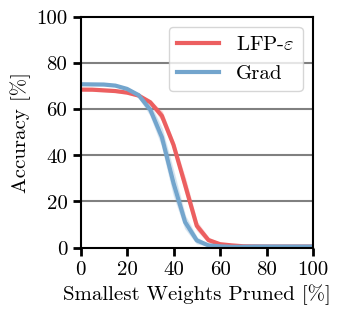

In [12]:
p_acc_file = os.path.join(savepath, f"p_accs_weight_unstructured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_acc_file) or recompute_pruning:
    p_accs = {}
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        print(name, lr)
        if name not in p_accs.keys():
            p_accs[name] = {}
        if lr not in p_accs[name].keys():
            p_accs[name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            canon = zcanon.SequentialMergeBatchNorm()
            handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
            layers = [module for module in transfer_wrappers[lr][name][seed][1].model.modules() if hasattr(module, "weight") and isinstance(module, torch.nn.Conv2d)]
            prune_acc = get_prune_acc(transfer_wrappers[lr][name][seed][1], layers, p=0.05, pruning_criterion="weight", structured=False, mask_function=get_prunemask)
            for handle in handles:
                handle.remove()
            transfer_wrappers[lr][name][seed][1].remove()
            p_accs[name][lr].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)

print(p_accs.keys())

fname = os.path.join(savepath, f"pruning_accuracies_weight_unstructured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_pruning_acc(p_accs, fname, pruning_criterion="weight")

In [13]:

# p_acc_file = os.path.join(savepath, f"p_accs_weight_structured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
# if not os.path.exists(p_acc_file) or recompute_pruning:
#     p_accs = {}
#     lr = investigated_lr
#     for name in transfer_wrappers[lr].keys():
#         print(name, lr)
#         if name not in p_accs.keys():
#             p_accs[name] = {}
#         if lr not in p_accs[name].keys():
#             p_accs[name][lr] = []

#         for seed in seeds:
#             transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
#             canon = zcanon.SequentialMergeBatchNorm()
#             handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
#             layers = [module for module in transfer_wrappers[lr][name][seed][1].model.modules() if hasattr(module, "weight") and isinstance(module, torch.nn.Conv2d)]
#             prune_acc = get_prune_acc(transfer_wrappers[lr][name][seed][1], layers, p=0.05, pruning_criterion="weight", structured=True, mask_function=get_prunemask)
#             for handle in handles:
#                 handle.remove()
#             transfer_wrappers[lr][name][seed][1].remove()
#             p_accs[name][lr].append(prune_acc)
#     joblib.dump(p_accs, p_acc_file)
# else:
#     p_accs = joblib.load(p_acc_file)

# print(p_accs.keys())


# fname = os.path.join(savepath, f"pruning_accuracies_weight_structured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
# plot_pruning_acc(p_accs, fname, pruning_criterion="weight")

dict_keys(['lfp-epsilon', 'vanilla-gradient'])


/tmp/ipykernel_724463/3624731735.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


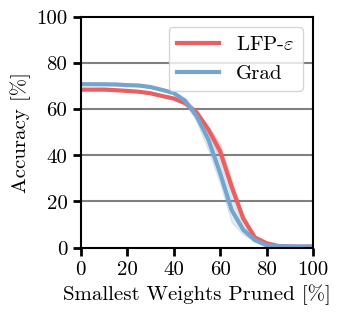

In [14]:
p_acc_file = os.path.join(savepath, f"p_accs_weight_local_unstructured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_acc_file) or recompute_pruning:
    p_accs = {}
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        print(name, lr)
        if name not in p_accs.keys():
            p_accs[name] = {}
        if lr not in p_accs[name].keys():
            p_accs[name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            canon = zcanon.SequentialMergeBatchNorm()
            handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
            layers = [module for module in transfer_wrappers[lr][name][seed][1].model.modules() if hasattr(module, "weight") and isinstance(module, torch.nn.Conv2d)]
            prune_acc = get_prune_acc(transfer_wrappers[lr][name][seed][1], layers, p=0.05, pruning_criterion="weight", structured=False, mask_function=get_prunemask_local)
            for handle in handles:
                handle.remove()
            transfer_wrappers[lr][name][seed][1].remove()
            p_accs[name][lr].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)

print(p_accs.keys())

fname = os.path.join(savepath, f"pruning_accuracies_weight_local_unstructured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_pruning_acc(p_accs, fname, pruning_criterion="weight")

In [15]:

# p_acc_file = os.path.join(savepath, f"p_accs_weight_local_structured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
# if not os.path.exists(p_acc_file) or recompute_pruning:
#     p_accs = {}
#     lr = investigated_lr
#     for name in transfer_wrappers[lr].keys():
#         print(name, lr)
#         if name not in p_accs.keys():
#             p_accs[name] = {}
#         if lr not in p_accs[name].keys():
#             p_accs[name][lr] = []

#         for seed in seeds:
#             transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
#             canon = zcanon.SequentialMergeBatchNorm()
#             handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
#             layers = [module for module in transfer_wrappers[lr][name][seed][1].model.modules() if hasattr(module, "weight") and isinstance(module, torch.nn.Conv2d)]
#             prune_acc = get_prune_acc(transfer_wrappers[lr][name][seed][1], layers, p=0.05, pruning_criterion="weight", structured=True, mask_function=get_prunemask_local)
#             for handle in handles:
#                 handle.remove()
#             transfer_wrappers[lr][name][seed][1].remove()
#             p_accs[name][lr].append(prune_acc)
#     joblib.dump(p_accs, p_acc_file)
# else:
#     p_accs = joblib.load(p_acc_file)

# print(p_accs.keys())

# fname = os.path.join(savepath, f"pruning_accuracies_weight_local_structured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
# plot_pruning_acc(p_accs, fname, pruning_criterion="weight")


dict_keys(['lfp-epsilon', 'vanilla-gradient'])


/tmp/ipykernel_724463/3624731735.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


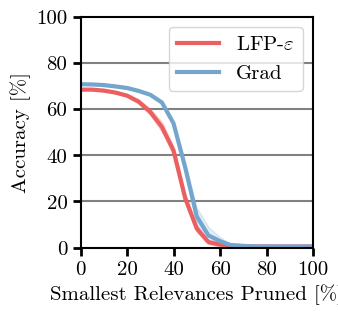

In [16]:

p_acc_file = os.path.join(savepath, f"p_accs_relevance_unstructured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
if not os.path.exists(p_acc_file) or recompute_pruning:
    p_accs = {}
    lr = investigated_lr
    for name in transfer_wrappers[lr].keys():
        print(name, lr)
        if name not in p_accs.keys():
            p_accs[name] = {}
        if lr not in p_accs[name].keys():
            p_accs[name][lr] = []

        for seed in seeds:
            transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
            canon = zcanon.SequentialMergeBatchNorm()
            handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
            layers = [module for module in transfer_wrappers[lr][name][seed][1].model.modules() if hasattr(module, "weight") and isinstance(module, torch.nn.Conv2d)]
            prune_acc = get_prune_acc(transfer_wrappers[lr][name][seed][1], layers, p=0.05, pruning_criterion="relevance", structured=False, mask_function=get_prunemask)
            for handle in handles:
                handle.remove()
            transfer_wrappers[lr][name][seed][1].remove()
            p_accs[name][lr].append(prune_acc)
    joblib.dump(p_accs, p_acc_file)
else:
    p_accs = joblib.load(p_acc_file)

print(p_accs.keys())

fname = os.path.join(savepath, f"pruning_accuracies_relevance_unstructured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
plot_pruning_acc(p_accs, fname, pruning_criterion="relevance")


In [17]:

# p_acc_file = os.path.join(savepath, f"p_accs_relevance_structured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.joblib")
# if not os.path.exists(p_acc_file) or recompute_pruning:
#     p_accs = {}
#     lr = investigated_lr
#     for name in transfer_wrappers[lr].keys():
#         print(name, lr)
#         if name not in p_accs.keys():
#             p_accs[name] = {}
#         if lr not in p_accs[name].keys():
#             p_accs[name][lr] = []

#         for seed in seeds:
#             transfer_wrappers[lr][name][seed][1].load(dataset_name_transfer, replace_last_layer=True)
#             canon = zcanon.SequentialMergeBatchNorm()
#             handles = canon.apply(transfer_wrappers[lr][name][seed][1].model)
#             layers = [module for module in transfer_wrappers[lr][name][seed][1].model.modules() if hasattr(module, "weight") and isinstance(module, torch.nn.Conv2d)]
#             prune_acc = get_prune_acc(transfer_wrappers[lr][name][seed][1], layers, p=0.05, pruning_criterion="relevance", structured=True, mask_function=get_prunemask)
#             for handle in handles:
#                 handle.remove()
#             transfer_wrappers[lr][name][seed][1].remove()
#             p_accs[name][lr].append(prune_acc)
#     joblib.dump(p_accs, p_acc_file)
# else:
#     p_accs = joblib.load(p_acc_file)

# print(p_accs.keys())

# fname = os.path.join(savepath, f"pruning_accuracies_relevance_structured_canonized-{investigated_lr}-{investigated_ep_lfp}-{investigated_ep_grad}.svg")
# plot_pruning_acc(p_accs, fname, pruning_criterion="relevance")
